In [1]:
import pandas as pd
import numpy as np
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time
import os.path
from os import path
from time import time, strftime, gmtime, localtime

# 1. Reading Elevation and Moisture File

In [2]:
Mst = pd.read_csv('MoistureFile/MoistureAndElevationUTMTraslated201610.csv')
Mst_o = pd.read_csv('MoistureFile/MoistureAndElevationUTMTraslated201610.csv')

# Converting the Dataframe into a Matrix
M=Mst.to_numpy()

X = M[:,0]
Y = M[:,1]
Z = M[:,3]

X = np.reshape(X, (1000, 1000))
Y = np.reshape(Y, (1000, 1000))
Z = np.reshape(Z, (1000, 1000))

## 1.1 Plotting the Surface

Text(0.5, 0, 'z - Elevation')

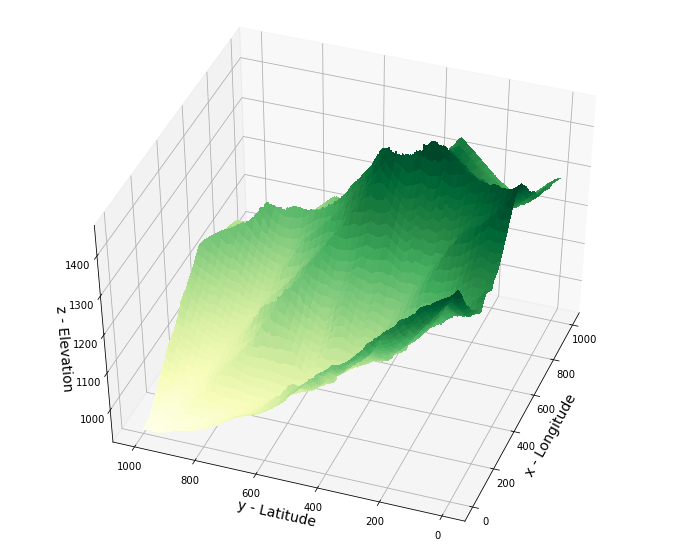

In [3]:
fig = plt.figure(figsize=(12,10))

ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, cmap=cm.YlGn,
                       linewidth=0, antialiased=False)
ax.view_init(45, 200)
ax.set_xlabel('x - Longitude',fontsize=14)
ax.set_ylabel('y - Latitude',fontsize=14)
ax.set_zlabel('z - Elevation',fontsize=14)

# 2. Creating the FDS file
## 2.1 Defining the Region Where the Simulation Takes Place

In [4]:
Min_x = 0
Max_x = 1000
Min_y = 0
Max_y = 1000
Mst = Mst[(Mst.x > Min_x-1) & (Mst.x < Max_x) & (Mst.y > Min_y-1) & (Mst.y < Max_y)]


# Defining the Resolution of the Meshes in Meters

In [5]:
R = 4
Mst = Mst[(Mst.x%R==0) & (Mst.y%R==0)]

# Definig the Resolution of the Obstacles in Meters

In [6]:
Ro = 4
Mst_o = Mst_o[(Mst_o.x%Ro==0) & (Mst_o.y%Ro==0)]

# Calculating the Range of the Elevation 

In [7]:
# Minimum and Maximum elevation
Min_z = math.floor(Mst['Elevation'].min())
Max_z = math.ceil(Mst['Elevation'].max())
print(Min_z, Max_z)

922 1463


## 2.2 Plotting the Real Data

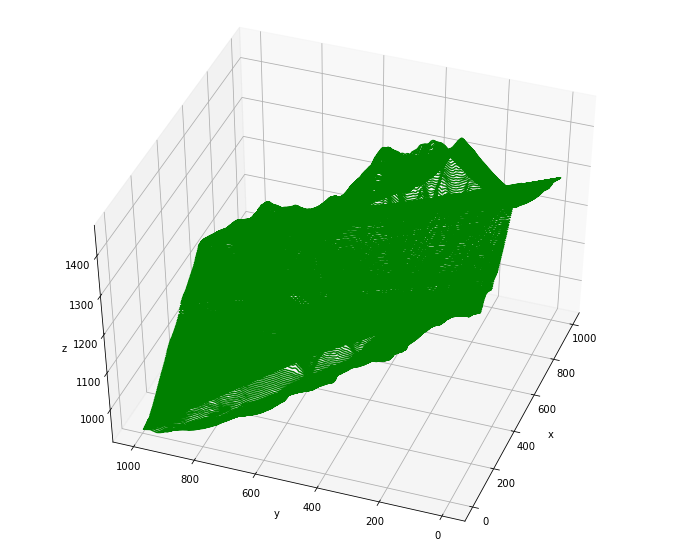

In [8]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.plot3D(Mst['x'], Mst['y'], Mst['Elevation'], 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.view_init(45, 200)
plt.show()

## 2.3 Plotting the Mathematical Domain

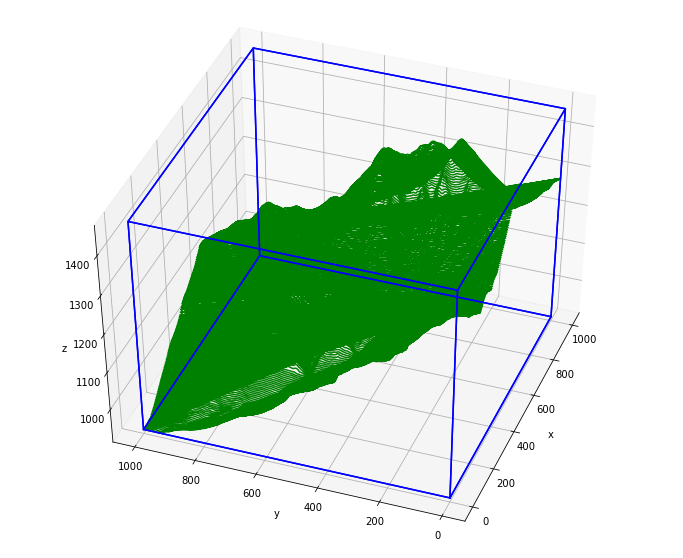

In [9]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')
ax.plot3D(Mst['x'], Mst['y'], Mst['Elevation'], 'green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Floor
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
zcube = [Min_z, Min_z, Min_z, Min_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# Ceil
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
zcube = [Max_z, Max_z, Max_z, Max_z, Max_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# left wall
xcube = [Min_x, Min_x, Min_x, Min_x, Min_x]
ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# right wall
xcube = [Max_x, Max_x, Max_x, Max_x, Max_x]
ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# back wall
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Max_y, Max_y, Max_y, Max_y, Max_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# front wall
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_x, Min_x, Min_x, Min_x, Min_x]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')


ax.view_init(45, 200)
plt.show()

# 2.4 Writing the FDS File 

In [10]:
# Defining the time variables

T_end    = 1.0
DT       = 0.1
NFRAMES  = int(2*T_end)
#NFRAMES  = 40

# Output File
PC = 1       # Select to use Predictor-Corrector Strategy
Rampa31 = 0  # Turn on/off Ramp value

foldername = f"FDSPROG_{R}_Ro_{Ro}_[{Min_x},{Max_x}]x[{Min_y},{Max_y}]_PC_{PC}_Rampa31_{Rampa31}_T_{T_end}_DT_{DT}"
filename = f"{foldername}.fds"
logname = f"{foldername}.log"

if not path.exists(f"FDSFiles/{foldername}"):
        os.mkdir(f"FDSFiles/{foldername}")
log_name     = f"FDSFiles/{foldername}/{logname}"
fds_filename = f"FDSFiles/{foldername}/{filename}"
fds     = open(fds_filename, 'w')
job_log = open(log_name, 'w')

############################################################
Time = strftime("Experiment done: %Y/%m/%d/ at %H:%M:%S",localtime())
job_log.write(f"{Time}\n\n")

job_log.write(f"Terrain Domain  = [{Min_x}, {Max_x}] x [{Min_y}, {Max_y}]\n")
job_log.write(f"Elevation Range = [{Min_z}, {Max_z}]\n\n")

job_log.write(f"Resolution = {R} meters \n\n")

24

### 2.4.1 Defining the Name of the Output Files

In [11]:
fds.write(f"&HEAD CHID='Chimney_tops_{R}m', TITLE='Simulation of Chimney Tops fire' /\n\n")

73

### 2.4.2 Defining the Pattern Mesh and Covering the Domain

In [12]:
Nmx = 2    # Number of meshes in x-direction 
Nmy = 2     # Number pf meshes in y-direction
Nmz = 2     # Nmber of Meshes  in z-direction

DX  = (Max_x-Min_x)/Nmx
DY  = (Max_y-Min_y)/Nmy
DZ  = (Max_z-Min_z)/Nmz

job_log.write(f"Number of Meshes = {Nmx*Nmy*Nmz} \n")

22

In [13]:
Nx = math.ceil(DX/R)     # Number of cells in x-direction first mesh (Resolution)
Ny = math.ceil(DY/R)     # Number of cells in y-direction first mesh (Resolution)
Nz = math.ceil(DZ/R)     # Number of cells in z-direction first mesh (Resolution)

job_log.write(f"Number of Cells = {Nx*Ny*Nz*Nmx*Nmy*Nmz} \n")
job_log.write(f"Required Memory = {math.ceil(Nx*Ny*Nz*Nmx*Nmy*Nmz/1000000)} GB \n\n")

25

### 2.4.3 Plotting the Submeshes

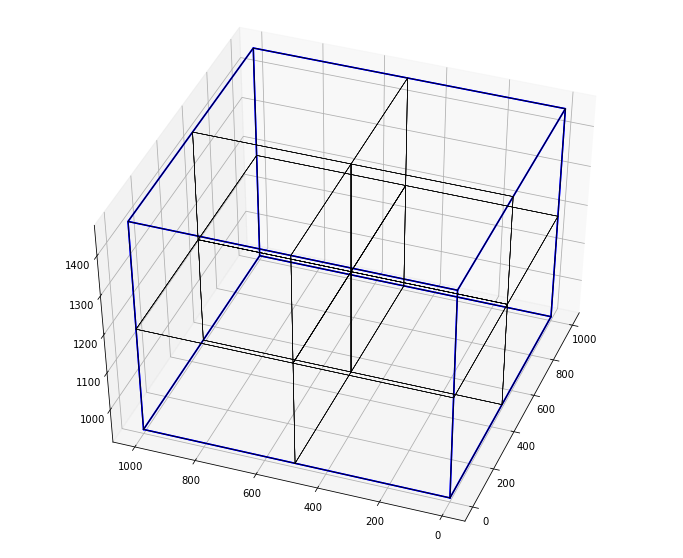

In [14]:
fig = plt.figure(figsize=(12,10))
ax = plt.axes(projection='3d')

# Floor
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
zcube = [Min_z, Min_z, Min_z, Min_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# Ceiling
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
zcube = [Max_z, Max_z, Max_z, Max_z, Max_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# left wall
xcube = [Min_x, Min_x, Min_x, Min_x, Min_x]
ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# right wall
xcube = [Max_x, Max_x, Max_x, Max_x, Max_x]
ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# back wall
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Max_y, Max_y, Max_y, Max_y, Max_y]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')

# front wall
xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
ycube = [Min_x, Min_x, Min_x, Min_x, Min_x]
zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
ax.plot3D(xcube,ycube,zcube,'blue')


#ax.view_init(45, 250)
#plt.show()
Min_x0 = Min_x
Max_x0 = Min_x0 + DX

Min_y0 = Min_y
Max_y0 = Min_y0 + DY

Min_z0 = Min_z
Max_z0 = Min_z0 + DZ


for i in range(Nmx):
    for j in range(Nmy):
        for k in range(Nmz):  
            Min_x = Min_x0 + i*DX
            Max_x = Max_x0 + i*DX
            
            Min_y = Min_y0 + j*DY
            Max_y = Max_y0 + j*DY
            
            Min_z = Min_z0 + k*DZ
            Max_z = Max_z0 + k*DZ
            # Floor
            xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
            ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
            zcube = [Min_z, Min_z, Min_z, Min_z, Min_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)

            # Ceil
            xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
            ycube = [Min_y, Min_y, Max_y, Max_y, Min_y]
            zcube = [Max_z, Max_z, Max_z, Max_z, Max_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)

            # left wall
            xcube = [Min_x, Min_x, Min_x, Min_x, Min_x]
            ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
            zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)

            # right wall
            xcube = [Max_x, Max_x, Max_x, Max_x, Max_x]
            ycube = [Min_y, Max_y, Max_y, Min_y, Min_y]
            zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)

            # back wall
            xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
            ycube = [Max_y, Max_y, Max_y, Max_y, Max_y]
            zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)

            # front wall
            xcube = [Min_x, Max_x, Max_x, Min_x, Min_x]
            ycube = [Min_y, Min_y, Min_y, Min_y, Min_y]
            zcube = [Min_z, Min_z, Max_z, Max_z, Min_z]
            ax.plot3D(xcube,ycube,zcube,'black',linewidth=0.5)
            ax.view_init(45, 200)
plt.show()  
        


In [15]:
fds.write(f"&MESH IJK={Nx},{Ny},{Nz}, XB={Min_x0},{Min_x0+DX},{Min_y0},{Min_y0+DY},{Min_z0},{Min_z0+DZ}, MULT_ID='mesh' / \n")
fds.write(f"&MULT ID='mesh', DX={DX}, DY={DY}, DZ={DZ}, I_LOWER=0, I_UPPER={Nmx-1}, J_LOWER=0, J_UPPER={Nmy-1}, K_UPPER={Nmz-1} /  \n\n")


106

### 2.4.4 Time Initialization

In [16]:
fds.write("&MISC TMPA=30., TERRAIN_CASE=.TRUE., TERRAIN_IMAGE='Chimney_tops_aerial.png', VERBOSE=.TRUE. / \n\n")

if PC==0:
    fds.write(f"&TIME T_END = {T_end}, DT={DT}, LOCK_TIME_STEP=.TRUE. /\n\n")
else:
    fds.write(f"&TIME T_END = {T_end}, DT={DT} / \n\n")

fds.write(f"&DUMP NFRAMES={NFRAMES}, DT_PART=100., CFL_FILE=.TRUE. /  \n\n")

job_log.write(f"Simulation Time     = {T_end} \n")
job_log.write(f"Time Step Size      = {DT} \n")
job_log.write(f"Number of Frames    = {NFRAMES} \n\n")

job_log.write(f"Predictor Corrector Strategy = {PC} \n\n")

35

### 2.4.5 Fire Variables Initialization

In [17]:
fds.write("&WIND DIRECTION=135., SPEED=5., SPONGE_CELLS=0, STRATIFICATION=.FALSE. /\n\n")

fds.write(f"&SURF ID='FIRE', HRRPUA=1500., COLOR='ORANGE', RAMP_Q='fire' /\n")
fds.write(f"&RAMP ID='fire', T= 0., F=0. /\n")
fds.write(f"&RAMP ID='fire', T= 1., F=1. /\n")
fds.write(f"&RAMP ID='fire', T= 30., F=1. /\n")
fds.write(f"&RAMP ID='fire', T= 31., F={Rampa31}. /\n\n")

job_log.write(f"&RAMP ID='fire', T= 0., F=0. /\n")
job_log.write(f"&RAMP ID='fire', T= 1., F=1. /\n")
job_log.write(f"&RAMP ID='fire', T= 30., F=1. /\n")
job_log.write(f"&RAMP ID='fire', T= 31., F={Rampa31}. /\n\n")


fds.write("&SLCF PBZ=1250., AGL_SLICE=1., QUANTITY='VELOCITY', VECTOR=.TRUE. /\n\n")

fds.write("&VENT MB='XMIN', SURF_ID='OPEN' /  \n")
fds.write("&VENT MB='XMAX', SURF_ID='OPEN' /  \n")
fds.write("&VENT MB='YMIN', SURF_ID='OPEN' /  \n")
fds.write("&VENT MB='YMAX', SURF_ID='OPEN' /  \n")
fds.write("&VENT MB='ZMAX', SURF_ID='OPEN' /  \n\n")
fds.write("&REAC FUEL='CELLULOSE', C=6, H=10, O=5, SOOT_YIELD=0.005 / \n\n")
fds.write("&SPEC ID='WATER VAPOR' / \n\n")

fds.write("&SURF ID                        = 'grass' \n")
fds.write("      MATL_ID(1,1:2)            = 'GENERIC VEGETATION','MOISTURE'\n")
fds.write("      MATL_MASS_FRACTION(1,1:2) = 0.937,0.063\n")
fds.write("      THICKNESS                 = 0.0002\n")
fds.write("      LENGTH                    = 0.21\n")
fds.write("      HEAT_TRANSFER_COEFFICIENT = 30.\n")
fds.write("      GEOMETRY                  = 'CYLINDRICAL' /\n\n")

fds.write("&SURF ID                        = 'needles' \n")
fds.write("      MATL_ID(1,1:2)            = 'GENERIC VEGETATION','MOISTURE'\n")
fds.write("      MATL_MASS_FRACTION(1,1:2) = 0.95,0.05\n")
fds.write("      THICKNESS                 = 0.02\n")
fds.write("      LENGTH                    = 0.21\n")
fds.write("      HEAT_TRANSFER_COEFFICIENT = 30.\n")
fds.write("      GEOMETRY                  = 'CYLINDRICAL' /\n\n")

fds.write("&MATL ID = 'GENERIC VEGETATION' \n")
fds.write("      DENSITY = 500.\n")
fds.write("      CONDUCTIVITY = 0.1\n")
fds.write("      SPECIFIC_HEAT= 1.5\n")
fds.write("      REFERENCE_TEMPERATURE = 200\n")
fds.write("      PYROLYSIS_RANGE = 30.\n")
fds.write("      NU_MATL = 0.2\n")
fds.write("      NU_SPEC = 0.8 \n")
fds.write("      SPEC_ID = 'CELLULOSE'\n")
fds.write("      HEAT_OF_COMBUSTION = 15600.\n")
fds.write("      HEAT_OF_REACTION = 418.\n")
fds.write("      MATL_ID  = 'CHAR' /\n\n")

fds.write("&MATL ID = 'MOISTURE' \n")
fds.write("      DENSITY = 1000.\n")
fds.write("      CONDUCTIVITY = 0.1\n")
fds.write("      SPECIFIC_HEAT= 4.184\n")
fds.write("      REFERENCE_TEMPERATURE = 100.\n")
fds.write("      PYROLYSIS_RANGE = 10.\n")
fds.write("      NU_SPEC = 1.0 \n")
fds.write("      SPEC_ID = 'WATER VAPOR'\n")
fds.write("      HEAT_OF_REACTION = 2500./\n\n")

fds.write("&MATL ID = 'CHAR'\n")
fds.write("      DENSITY  = 100.\n")
fds.write("      CONDUCTIVITY = 0.1 \n")
fds.write("      SPECIFIC_HEAT = 1.0 / \n\n")

fds.write("&MATL ID='DIRT'\n")
fds.write("      CONDUCTIVITY = 0.25\n")
fds.write("      SPECIFIC_HEAT = 2.\n")
fds.write("     DENSITY = 1300. /\n\n")

fds.write("&PART ID='foliage', DRAG_COEFFICIENT=1.0, SURF_ID='needles', SAMPLING_FACTOR=5,\n")
fds.write("      QUANTITIES='PARTICLE TEMPERATURE','PARTICLE MASS','PARTICLE DIAMETER', STATIC=.TRUE., COLOR='GREEN' / \n\n")

fds.write("&PART ID='grass', DRAG_COEFFICIENT=1.0, SURF_ID='grass', SAMPLING_FACTOR=958,\n")
fds.write("      QUANTITIES='PARTICLE TEMPERATURE','PARTICLE MASS','PARTICLE DIAMETER', STATIC=.TRUE., COLOR='BROWN' /\n\n")

fds.write("&SURF ID = 'surf1', RGB = 122,117,48, MATL_ID='DIRT', THICKNESS=0.2, PART_ID='grass', PARTICLE_SURFACE_DENSITY=1.0 / \n")
fds.write("&SURF ID = 'surf2', RGB = 0,100,0, MATL_ID='DIRT', THICKNESS=0.2 / \n\n")



69

### 2.4.6 Location of the Fire

In [18]:
rows = Mst_o.shape[0]
# Position of the ignition point
Location = [499,499]
# Locating that position in the Moisture File
Indice = Mst_o[(Mst_o['x'] < Location[0]+5) & (Mst_o['x'] > Location[0]-4) & (Mst_o['y'] < Location[1]+2) & (Mst_o['y'] > Location[1]-2)].index
Indice2 = [i for i in Mst_o.index if i not in Indice.values]

job_log.write(f"Coordinates of the Fire   = {Location}")

38

## 2.4.7 Obstruction 

In [19]:
# Writing the location of the fire
for ind in Indice.values:
    fds.write(f"&OBST XB={Mst_o['x'][ind]},{Mst_o['x'][ind]+Ro},{Mst_o['y'][ind]},{Mst_o['y'][ind]+Ro},{Min_z0},{Mst_o['Elevation'][ind]} SURF_IDS='FIRE','surf1' /\n")

# Writing the obstacles  [x for x in xrange(100) if x != 50]

for i in Indice2: 
    fds.write(f"&OBST XB={Mst_o['x'][i]},{Mst_o['x'][i]+Ro},{Mst_o['y'][i]},{Mst_o['y'][i]+Ro},{Min_z0},{Mst_o['Elevation'][i]} SURF_ID='surf1'/\n")
    
fds.write("\n&TAIL /")


8

# 2.5 Writing the bsub File

In [20]:
bsub_name     = f"FDSFiles/{foldername}/fds_testing.bsub"
bsub          = open(bsub_name, 'w')

bsub.write("#!/bin/bash\n")
bsub.write("#BSUB -n 1\n")
bsub.write("#BSUB -J mesh_\n")
bsub.write("###BSUB -x\n")
bsub.write('###BSUB -R "span[hosts=1]"\n')
bsub.write("#BSUB -o /home/leobardovalera/experiments/mesh_%J.out\n")
bsub.write("#BSUB -e /home/leobardovalera/experiments/mesh_%J.err\n")
bsub.write("##BSUB -W 1:00\n\n")

bsub.write("export OMP_NUM_THREADS=4\n")
bsub.write(f"mpiexec -n {Nmx*Nmy*Nmz} ~/fds/Build/mpi_gnu_linux_64/fds_mpi_gnu_linux_64 {filename}")


127

# 3 Closing All the Files

In [21]:
fds.close()
job_log.close()
bsub.close()